## Brief CPI S&P 500 Correlation Investigation

Here is a very brief investigation of potential correlation between the CPI and S&P 500 multipliers.

In [1]:
## The following packages are used
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
snp = pd.read_csv("Data/snp500.csv",
                     parse_dates = ['date'])
cpi = pd.read_csv("data/cpi.csv",
                     parse_dates = ['date'])

In [3]:
## get_price(df, date, years)
## this will get the closing price on the trading day
## closest to the given date years years into the future.
## The given df should be the historical data on the index
def get_price(df, date, years):
    # find_date is the date years years into the future
    find_date = date + relativedelta(years=years)
    
    # the longest the NY stock exchange was ever not trading
    # was two weeks for the given index data
    for i in range(15):
        # check if the date is one of the trading days
        if find_date + timedelta(days = i) in df.date.values:
            # if so return the closing price on that day
            return df.loc[df.date == find_date + timedelta(days = i)].close.values[0]

## get_date(df, date, years)
## This function returns the trading day closest
## to the given date years years into the future
def get_date(df, date, years):
    # the date we want to compare to
    find_date = date + relativedelta(years=years)
    
    # the longest the NY stock exchange was ever not trading
    # was two weeks for the given indices
    for i in range(15):
        # check if the date is one of the trading days
        if find_date + timedelta(days = i) in df.date.values:
            # if so return the closing price on that day
            return find_date
        
## find_last_date(df, years)
## This function returns the last possible trading day
## we can consider that has a trading day years years in the future.
## for example, if our data ended on June 2, 2022 and years = 30
## find_last_date would return June 2, 1992
def find_last_date(df, years):
    # take the last trading day and subtract years years
    last_possible_date = df.date.max() - relativedelta(years=years)
    
    # if the df has trading days before the given last_possible_date
    if len(df.loc[df.date <= last_possible_date]) > 0:
        # record the index of the trading day closest but not after to
        # last_possible_date
        i = df.loc[df.date <= last_possible_date].index[0]
    else:
        # otherwise return -99
        i = -99
    
    return i

## get_inflation(cpi, i, years)
## This calculates the inflation multiplier from a given
## index for an elapsed time of years years
def get_inflation(cpi, i, years):
    return cpi.loc[i+years*12,'cpi']/cpi.loc[i,'cpi']

## 40 Year Multipliers

In [4]:
## First I recorded the multipliers for a 40 year 
## investment window

snp_rois = []
snp_month = []
snp_year = []

for i in range(len(snp)-1, find_last_date(snp, 40), -1):
    snp_rois.append(get_price(snp, snp.date[i], 40)/(snp.close[i]))
    snp_month.append(snp.date[i].month)
    snp_year.append(snp.date[i].year)
    
inflations = []
cpi_month = []
cpi_year = []

for i in range(len(cpi)-12*40):
    inflations.append(get_inflation(cpi, i, 40))
    cpi_month.append(cpi.date[i].month)
    cpi_year.append(cpi.date[i].year)

In [5]:
cpi_40 = pd.DataFrame({'month':cpi_month,
                          'year':cpi_year,
                          'roi':inflations})

snp_40 = pd.DataFrame({'month':snp_month,
                          'year':snp_year,
                          'roi':snp_rois})

In [6]:
## Here we will match the daily SNP multiplier data
## with commensurate CPI multiplier data
######
## For a given trading day, we use the extracted month
## and year to find a matching inflation multiplier
cpi_compare = []
snp_compare = []

for i in cpi_40.index:
    year = cpi_40.year[i]
    month = cpi_40.month[i]
    cpi_roi = cpi_40.roi[i]
    
    
    for roi in snp_40.loc[(snp_40.year==year) &
                             (snp_40.month==month)].roi.values:
        cpi_compare.append(cpi_roi)
        snp_compare.append(roi)

In [7]:
## The correlation between these two
np.corrcoef(cpi_compare, snp_compare)

array([[1.        , 0.03050414],
       [0.03050414, 1.        ]])

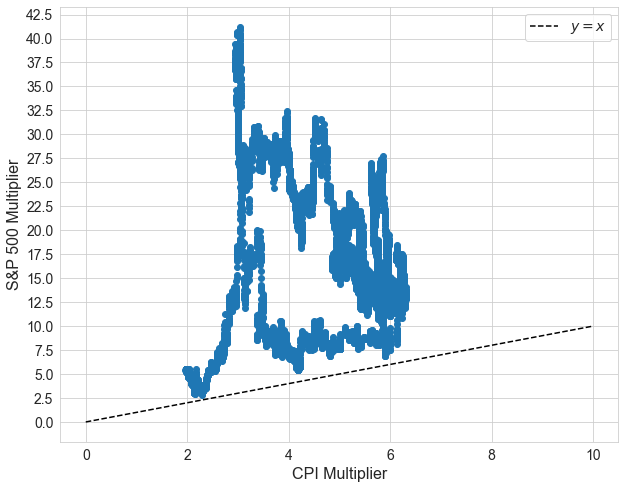

In [8]:
## Plotting the comparable multipliers against
## one another along with the line y = x
plt.figure(figsize=(10,8))
plt.scatter(cpi_compare, snp_compare)
plt.plot([0,10], [0,10], 'k--', label="$y=x$")

plt.legend(fontsize=14)

plt.yticks(np.arange(0,45,2.5), fontsize=14)
plt.xticks(fontsize=14)

plt.xlabel("CPI Multiplier", fontsize=16)
plt.ylabel("S&P 500 Multiplier", fontsize=16)

plt.show()

#### Repeating correlation calculate for each year interval up to 40

In [9]:
cpi_snp_corrs = []

for years in range(1,41):
    print(years)
    snp_rois = []
    snp_month = []
    snp_year = []

    for i in range(len(snp)-1, find_last_date(snp, years), -1):
        snp_rois.append(get_price(snp, snp.date[i], years)/(snp.close[i]))
        snp_month.append(snp.date[i].month)
        snp_year.append(snp.date[i].year)

    inflations = []
    cpi_month = []
    cpi_year = []

    for i in range(len(cpi)-12*years):
        inflations.append(get_inflation(cpi, i, years))
        cpi_month.append(cpi.date[i].month)
        cpi_year.append(cpi.date[i].year)
    
    cpi_mults = pd.DataFrame({'month':cpi_month,
                          'year':cpi_year,
                          'roi':inflations})

    snp_mults = pd.DataFrame({'month':snp_month,
                              'year':snp_year,
                              'roi':snp_rois})
    
    cpi_compare = []
    snp_compare = []

    for i in cpi_mults.index:
        year = cpi_mults.year[i]
        month = cpi_mults.month[i]
        cpi_roi = cpi_mults.roi[i]


        for roi in snp_mults.loc[(snp_mults.year==year) &
                                 (snp_mults.month==month)].roi.values:
            cpi_compare.append(cpi_roi)
            snp_compare.append(roi)
            
    cpi_snp_corrs.append(np.corrcoef(cpi_compare, snp_compare)[0,1])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


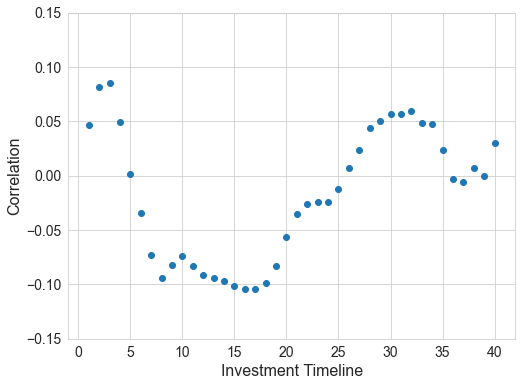

In [10]:
plt.figure(figsize=(8,6))

plt.scatter(range(1, 41), cpi_snp_corrs)

plt.xlabel("Investment Timeline", fontsize=16)
plt.ylabel("Correlation", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim([-.15, .15])

plt.show()